# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `28`
* Students: `Guillain, Léonore Valentine; Pase, Francesco; Rusu, Cosmin-Ionut; Zhuang, Ying`
* Dataset: `Flight Routes`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [3]:
adjacency = np.load('adjacency.npy') # the adjacency matrix
n_nodes =  adjacency.shape[0] # the number of nodes in the network

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [4]:
def compute_laplacian(adjacency):
    """Computes the laplacian given the adjacency matrix"""
    degrees = adjacency.sum(axis=1)
    
    #Compute D and D^-1/2, as D is diagonal we can just use element wise computation
    D = np.diag(degrees)
    D_inv_sqrt = scipy.sparse.csc_matrix(np.diag(1 / (np.sqrt(degrees))))

    #Calculate the different laplacians
    laplacian_combinatorial =  scipy.sparse.csr_matrix(D - adjacency)
    laplacian_normalized =  scipy.sparse.csr_matrix.dot(D_inv_sqrt, scipy.sparse.csr_matrix.dot(laplacian_combinatorial, D_inv_sqrt))
    
    return laplacian_normalized, laplacian_combinatorial, D_inv_sqrt
    
laplacian_normalized, laplacian_combinatorial, D_inv_sqrt = compute_laplacian(adjacency)

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [5]:
laplacian =  laplacian_normalized

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [6]:
#We compare different methods & choose the most appropoiate one
%timeit np.linalg.eig(laplacian.toarray())

24.6 s ± 273 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit scipy.linalg.eig(laplacian.toarray())

27 s ± 3.37 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
#takes way too long to run, +2 minutes for a single execution
#%timeit scipy.sparse.linalg.eigs(laplacian.asfptype(), k=n_nodes-2)
#matrix is symetric
print(f'Our matrix is symetric: {np.allclose(adjacency, adjacency.T)}')
#%timeit scipy.sparse.linalg.eigsh(laplacian.asfptype(), n_nodes-2)

Our matrix is symetric: True


In [9]:
%timeit np.linalg.eigh(laplacian.toarray())

7.53 s ± 150 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit scipy.linalg.eigh(laplacian.toarray())

26.8 s ± 3.74 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
eigenvalues, eigenvectors =  np.linalg.eigh(laplacian.toarray())

#sanity check
assert eigenvectors.shape == (n_nodes, n_nodes)

#sort the eigenvalues
indexes_sorted = np.argsort(eigenvalues)
eigenvalues_sorted = np.sort(eigenvalues)
eigenvector_sorted = eigenvectors[:,indexes_sorted]

Justify your choice of eigensolver.

**Your answer here.**

We use the numpy eigensolver <span style='color:red'>**np.linalg.eigh()**</span> for symetric matrixes (using the dense matrix) because it is the fastest and has the most stable results, as can be seen above. Additionaly scipy.sparse's implementatios <span style='color:blue'>scipy.sparse.linalg.eigs()</span> and <span style="color:blue">scipy.sparse.linalg.eigsh()</span> are not able compute all the $\textit{n_nodes}$ eigenvectors.

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

**Your answer here.**

The matrix $S \in \mathbb{R}^{N \times M}$, where $M = |\mathcal{E}|$ and $N = |\mathcal{V}|$, is the Incidence Matrix of a (directed) graph, whos entries are defined to be:

 \begin{equation}
    S(i,j) =
    \begin{cases}
      +1, & \text{if}\ \exists k : e_j = (v_i, v_k) \in \mathcal{E} \\
      -1, & \text{if}\ \exists k : e_j = (v_k, v_i) \in \mathcal{E} \\
      0, & \text{otherwise}
    \end{cases}
  \end{equation}
  
If we think of $\vec{x} \in \mathbb{R}^N$ as a function defined in the graph space (every vertex of the graph is a point of the Domain), the value $S^\top \vec{x} \in \mathbb{R}^M$ denotes the gradient of $\vec{x}$ over the $M$ edges. 


Indeed $$(S^\top \vec{x})_j = \sum_h S^\top(j, h) \cdot x_h =  x_i - x_k$$ —where pedix $h$ denotes the the $h$-th element of a vector and j is the edge connecting node $i$ to $k$— is the difference of the function computed at two points that are close to each other on the domain. Hence, giving the gradient of $\vec{x}$. The direction of the gradient is given by the direction of the edge connecting the nodes ($\textit{oriented Incidence Matrix}$).


### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Your answer here.**
We can easily see that:

$$
 \| S^\top u_k \|_2^2 \stackrel{(1)}{=} < (S^\top u_k)^T, S^\top u_k >\stackrel{(2)}{=} < u_k^T S, S^\top u_k > \stackrel{(3)}{=} u_k^T SS^\top u_k \stackrel{(4)}{=} u_k^T L u_k \stackrel{(5)}{=} \lambda_k u_k^Tu_k \stackrel{(6)}{=} \lambda_k
$$

- (1) by definition of Euclidian norm
- (2) by property of Transpose
- (3) by property of Inner product
- (4) by property of Laplacian
- (5), (6) the eigenvectors decomposition finds orthonormal vectors.

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

**Your answer here.**
By the definition of the Euclidian norm and our answer in question 3 we have $\| S^\top x \|_2^2 = \sum_{i\sim k}(x_i - x_k)^2$ . This is a measure of the smoothness of the function $x$. We note that, if the graph is weighted, we have: $\| S^\top x \|_2^2 = \sum_{i\sim k}w_{i,k}(x_i - x_k)^2$, where $w_{i,k}$ is the weight of the edge $j$. Given this, $\| S^\top x \|_2^2 = x^TLx$ accumulates all the squared variations of the function (Laplacian operator in the graph domain) along all the edges (positive values). Thus giving an indication of how fast the function varies over the network.

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

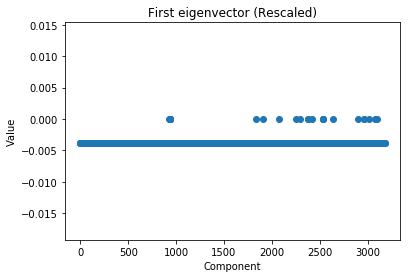

Number of nonzero elements in the first eigenvector : 3154


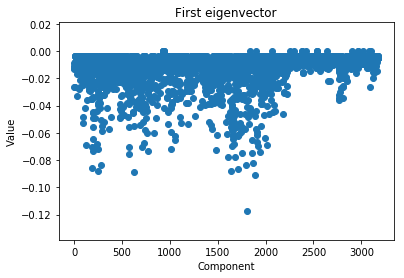

In [12]:
#We multiply u0 by D^(-1/2) to level all the nonzero elements of the vector
plt.scatter(np.arange(eigenvalues.shape[0]), D_inv_sqrt.toarray() @ eigenvector_sorted[:,1])
plt.title("First eigenvector (Rescaled)")
plt.xlabel("Component")
plt.ylabel("Value")
plt.show()

#non leveled eigenvector
plt.scatter(np.arange(eigenvalues.shape[0]), eigenvector_sorted[:,1])
plt.title("First eigenvector")
plt.xlabel("Component")
plt.ylabel("Value")
print("Number of nonzero elements in the first eigenvector :", sum(eigenvector_sorted[:,1]<-0.00001))

**Your answer here.**

As we saw in class, the first eigenvector $\textbf{u}_0$ of the combinatorial laplacian lies along the direction of the vector $\textbf{1}$ (it is not exactly the $\textbf{one}$ vector because of the eigensolver) if the network presents a single connected components. For the normalized laplacian, it is the same vector where each component is rescaled by the squared root of the degree of such component (node). In our case, given that our network is not a single connected component, $\textbf{u}_0$ is an indicator function indicating the precence of disconnected components.

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

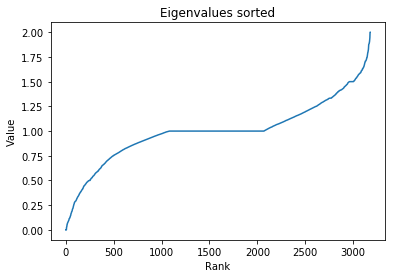

In [13]:
plt.plot( eigenvalues_sorted)
plt.title("Eigenvalues sorted")
plt.xlabel("Rank")
_ = plt.ylabel("Value")

Sum of eigenvalues is : 3179.0


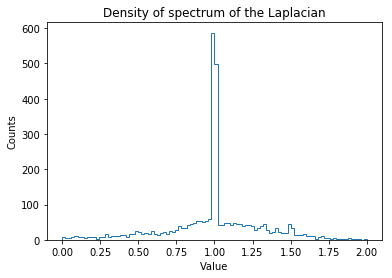

In [14]:
plt.hist(eigenvalues_sorted, histtype='step', bins=100, log=False)
plt.title("Density of spectrum of the Laplacian")
plt.xlabel("Value")
plt.ylabel("Counts")
#It should be equals to the number of nodes, and it is
print("Sum of eigenvalues is :" , np.sum(eigenvalues_sorted))

**Your answer here.**

For the normalized laplacian, the sum of the eigenvalues is equal to the number of nodes in the graph, consequently the distribution of such values has this constraint. The density of the spectrum is very interesting because it reveals about the sctructure of our graph. The shape of the density is an indication that our network is scale-free, as described in [paper link](http://ceec.fnts.bg/telecom/2017/documents/CD2017/Papers/9.pdf).




How many connected components are there in your graph? Answer using the eigenvalues only.

Text(0.5, 0, 'Index')

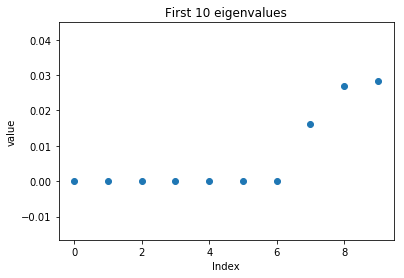

In [15]:
#We scatter the first 10 to see the connected components
plt.scatter(np.arange(10), eigenvalues_sorted[0:10])
plt.title("First 10 eigenvalues")
plt.ylabel("value")
plt.xlabel("Index")

**Your answer here.**

In our network we have 7 connected components. We can infer this by looking at the algebraic multiplicity of the eigenvalues zero that's equal to the number of connected components. This is true for both the matrices.

Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**Your answer here.**

For both the matrices the minimum value is zero, as the matrices are positive semidefinite. Then, given that we used the normalized laplacian, the largest possible eigenvalue is 2 (it is equal to 2 if the graph is bipartite). For the combinatorial case, the largest eigenvalue is clearely upper bounded by the fact that, for any matrix, the sum of the eigenvalues is equal to the Trace of the matrix. For the laplacian matrices, this is twice the number of edges of the graph. Reasearching we found that as a consequence of the [Gershgorin's Theorem](https://en.wikipedia.org/wiki/Gershgorin_circle_theorem) the largest eigenvalue $\lambda_n$ is at most twice the maximum vertex degree.

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**Your answer here.**

It is used to preform dimensionality reduction: go from high dimensional datapoints to a lower dimensional equivalent, while preserving similarities (locality preservation) in among the datapoints. In this sense, this technique is mostly used to better visualize graphs in a low-dimensional space and to detect strcutures in the datasets from which graphs are derived.  

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [16]:
#calculate largest component
eig_v = (D_inv_sqrt.toarray() @ eigenvector_sorted)[:,0:7]
mean = np.median(eig_v, axis=0)
indixes = np.where(abs(eig_v-mean) < 1e-10, 1, 0)

mask_largest_component = indixes.T[np.argmin(indixes.sum(axis=0))]

In [17]:
#recomputing eigendecomposition
laplacian_normalized_, laplacian_combinatorial_, D_inv_sqrt_ = compute_laplacian(
    adjacency[mask_largest_component > 0][:, mask_largest_component > 0])

Plot the nodes embedded in 2D. Comment on what you see.

In [18]:
#EIGHS SOLVER
eigen_val, eigen_vec = scipy.sparse.linalg.eigsh(
    scipy.sparse.csc_matrix(laplacian_normalized_).asfptype(), 20, which='SM')

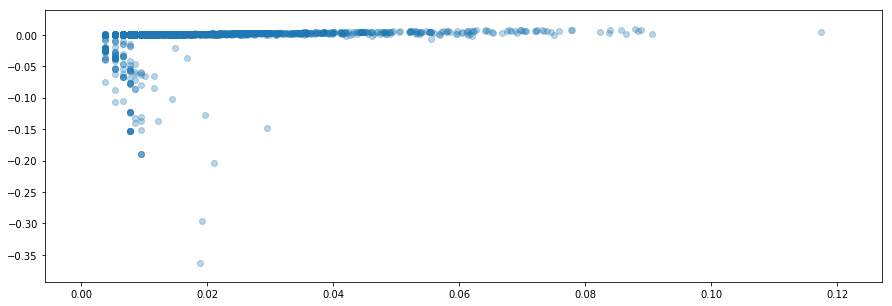

In [19]:
plt.figure(figsize=(15,5))
plt.scatter( eigen_vec[:,0], eigen_vec[:,1], alpha=0.3)

**Your answer here.**

We can observe that most of the nodes have similar positions leading to overlap in the plot, indicating that our network is pretty dense. We see also very few outlier nodes. The "L" shape of our eigenmap shows that most nodes have zero along the Y-axis; then we have some nodes that have non-zeros along Y-axis and small values along the X-axis. Thus we hypothesis that our network can be split into 2 components.

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Your answer here.**


As stated before, the embedding procedure preserves local similarity between points mapping linking similarities (graph topology) to euclidean proximity.

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

Text(0, 0.5, 'Value')

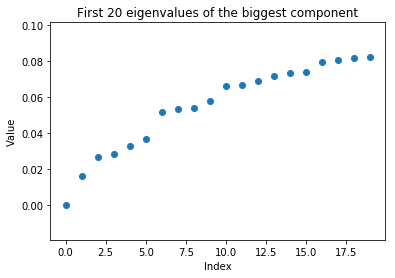

In [20]:
plt.scatter(np.arange(20), eigen_val[0:20])
plt.title("First 20 eigenvalues of the biggest component")
plt.xlabel("Index")
plt.ylabel("Value")

**Your answer here.**

$k$ is the number of clusters we will get, $d$ is the dimensionality of our datapoints. We chose $d$ as to maximize the gap between two consecutive eigenvalues. As we can see on the above plot we have smooth transitions among the eigenvalues but 6 and 2 have the largest gaps, with 6 seeming slightly larger. Hence we choose 6.

**CHECK THIS**
As we have no ground truth and do thus not know how many clusters we should have, we have no choice but to heuristically find a k that gives us "good" clusters. By looking at the plot in 2-dimension, we decided to split our graph in 2 components (X and Y axis), and we later see that using k=5 also gives good, but different results.

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [21]:
#We want 2 clusters, so we use the Fiedler Vector
labels = np.where(eigen_vec[:,1] < 0, 1, 0)

In [22]:
#alternative, gives different results!
kmeans = KMeans(n_clusters=5)
# Normalized vectors and Fitting the input data
kmeans = kmeans.fit(eigen_vec[:,:7])
# Getting the cluster labels
labels_kmeans = kmeans.predict(eigen_vec[:,:7])

In [23]:
#checking how many nodes are in each cluster
d = {}
for label in labels:
    if label not in d.keys():
        d[label] = 1
    else :
        d[label] += 1
print("Size of Clusters: ", d)

Size of Clusters:  {0: 2962, 1: 192}


### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

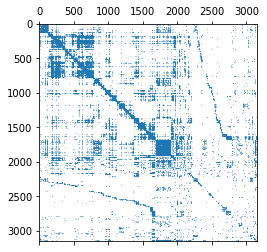

In [24]:
#we sort the list (label, index of node) and the retrive the index
L = [ (labels_kmeans[i],i) for i in np.arange(len(labels_kmeans)) ]
L.sort()
reorder = [i for l, i in L]
plt.spy(adjacency[reorder][:, reorder], markersize=0.1)

**Your answer here.**

We expect to see a quasi-diagonal matrix, but given the density of our components it is not easy to isolate good clusters. We can observe a big block component along the diagonal that represents the most connected part of our network (with our hubs). Moreover, within such block we can observe almost 3 pretty dense groups of nodes. On the lower-right corner of the matrix instead we can see the poorely connected nodes connected to the biggest block with just few links.

(We note that both reordering by the fiedler vector clusters and 5-means clusters gives us nearly identical adjacency )

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

**Your answer here**

While we don't have a ground truth label, our nodes correspond to airports and thus are embedded on a 2D hyperplane in 3D. We check if our clustering corresponds to something on the map by plotting the physical location of the nodes. This gives us an intuitive way to qualitatively evaluate the clusters, as we can use our knowledge of geography to infer if the cluster is "meaningful" in some way or not.

As we can see, we were able to isolate airports placed in the north-west of the United States together with Alaska's airports. This could suggest that in order to reach Alaska we should stop in one of the US Airports highlighted in our map. 

The alternative clustering using k-mean with k=5 is also evaluated here. The results are interesting as well, as they cluster together "hard to get to" places that are close in location. 

However, the cluster does not isolate all "isolated" locations, only ones close to north america. We suspect that there should be more clusters (as there are more isolated nodes, also see Q15), but increasing k-leads to very spread out and random looking clusters. Hence using K-means does give us some interessting clusters, but it can not isolate all the ones we would expect to see (consider pacific islands for instance).

Additionaly we note that clustering by the Fiedler vector is able to give a more equially sized split and it gives the two different directions highlighted in the 2D embedding, which is not the case for k means clustering (Question 14).

In [25]:
import pandas as pd
features = pd.read_csv("features.csv", index_col=0)
locations = np.array(features[mask_largest_component > 0].apply(lambda x : [x.Latitude, x.Longitude], axis=1).tolist())

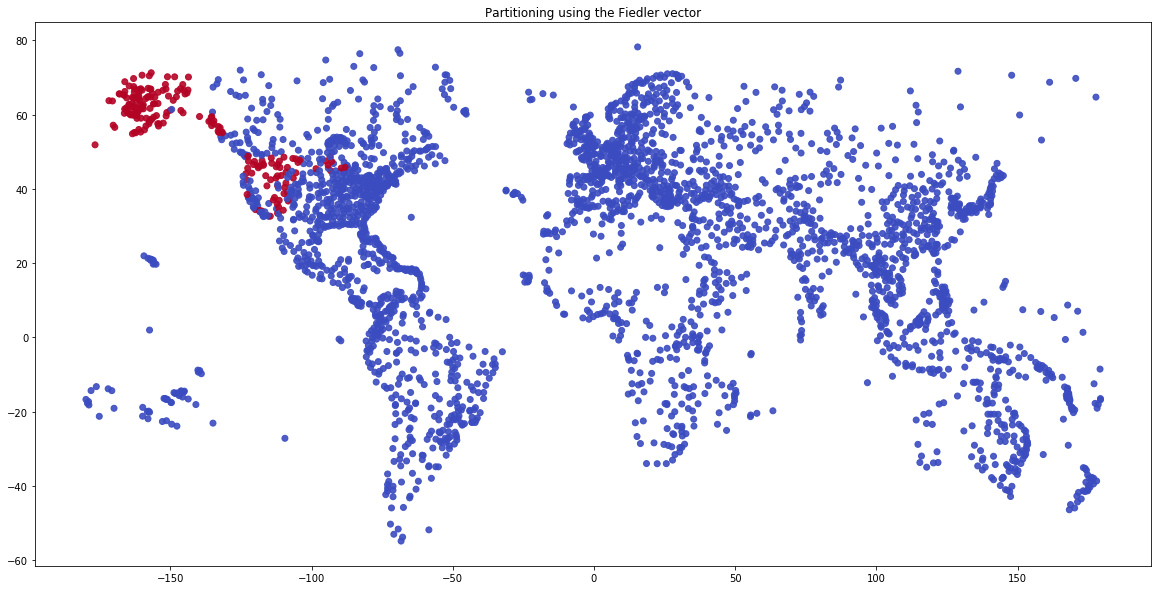

In [26]:
plt.figure(figsize=(20, 10))
plt.title('Partitioning using the Fiedler vector')
_ = plt.scatter(locations[:,1], locations[:,0], alpha=0.9, cmap=plt.cm.coolwarm, c=labels)

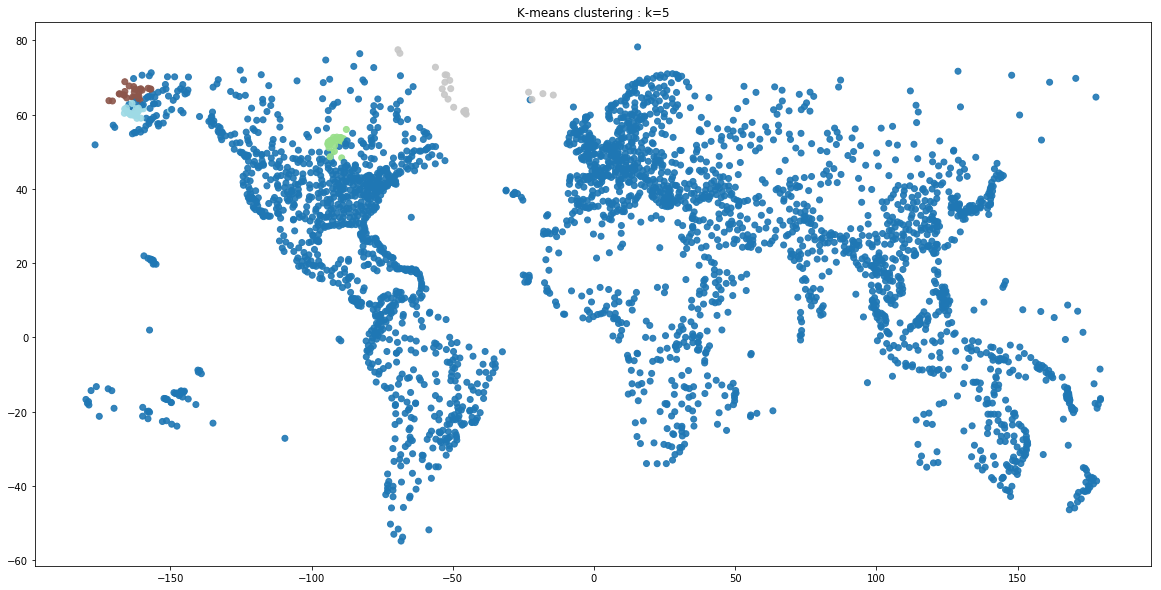

In [27]:
plt.figure(figsize=(20, 10))
plt.title('K-means clustering : k=5')
_ = plt.scatter(locations[:,1], locations[:,0], alpha=0.9, cmap=plt.cm.tab20, c=labels_kmeans)

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

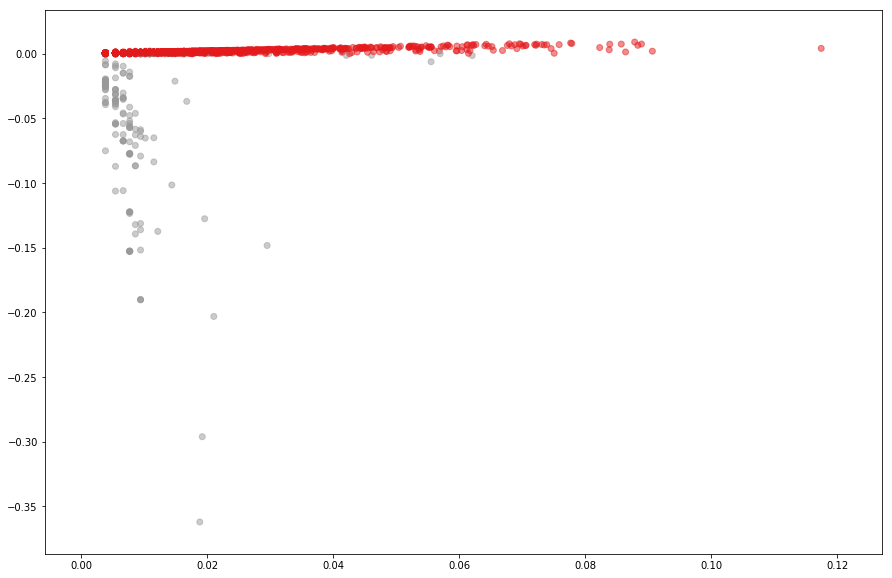

In [28]:
#move code from above here
plt.figure(figsize=(15, 10))
plt.scatter(eigen_vec[:,0], eigen_vec[:,1], alpha=0.5, cmap=plt.cm.Set1, c=labels)

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**
**TO CHECK**

We use the row components of the eigenvectors as features for the clustering because points that are close to each other in the eigenmaps representation have strong connections to each other in the graph representaion, and so grouping them in the euclidean space is similar to grouping nodes that are very connected to each other in the original network. 

In other words, the eigenvectors naturally partition the graph into clusters such that node in a cluster are more connected to nodes within that cluster than to nodes outside of the cluster.

We could use any other numerical values associated to the graph for clustering, so long they define a similarity mesure between the nodes. An example of such a feature matrix is the [topological overlap matrix](http://networksciencebook.com/chapter/9#hierarchical)

In the broader sense of clustering, modularity can be used to find clusters (communities), as shown below, this gives quite interessting clusters:

In [29]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.colors as mcolors

In [30]:
graph = nx.from_numpy_array(adjacency[mask_largest_component > 0][:, mask_largest_component > 0])

In [31]:
communities = list(greedy_modularity_communities(graph))

In [32]:
print('We get {} clusters'.format(len(communities)))

We get 41 clusters


In [33]:
d = {}
for i, c in enumerate(communities):
    for member in c:
        d[member] = i

In [34]:
modularity = pd.Series(d).sort_index().tolist()

In [35]:
colors1 = plt.cm.Set1_r(0)
colors2 = plt.cm.tab20b(list(range(20)))
colors3 = plt.cm.tab20c(list(range(20)))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2, colors3))
mymap = mcolors.ListedColormap(colors)

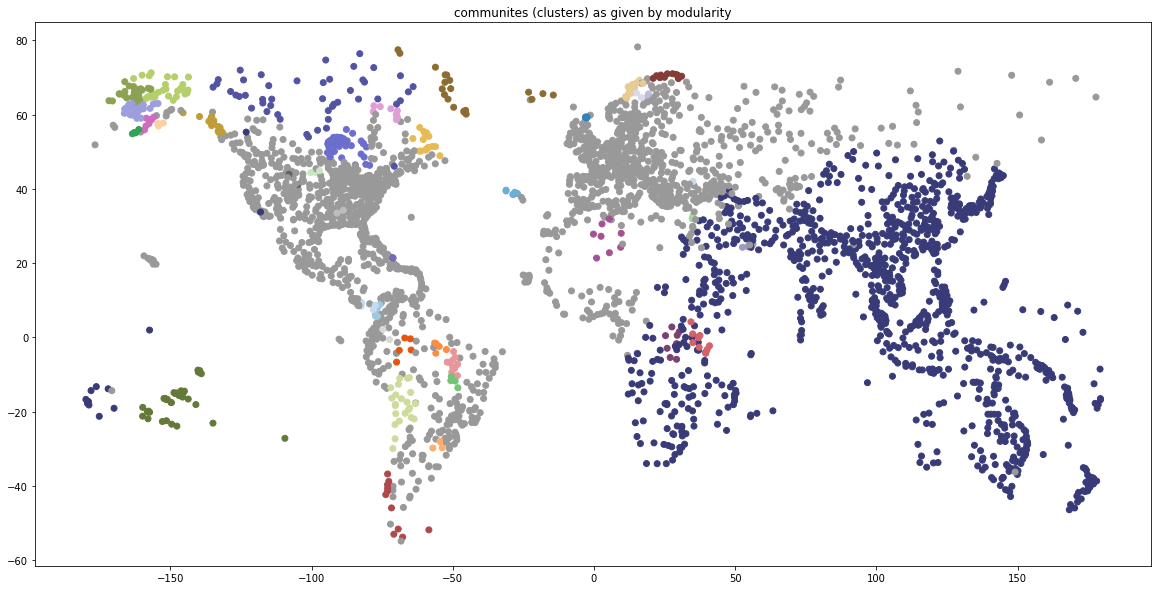

In [36]:
plt.figure(figsize=(20, 10))
plt.title('communites (clusters) as given by modularity')
plt.scatter(locations[:,1], locations[:,0], cmap=mymap, c=modularity)